<a href="https://colab.research.google.com/github/un1qqe/NLP-Classification-youtube-comments-/blob/main/youtube_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-23 16:21:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-23 16:21:03 (85.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import unzip_data

In [3]:
unzip_data('/content/youtube_dataset.csv.zip')

In [4]:
import pandas as pd


In [5]:
data=pd.read_csv('/content/youtube_dataset.csv.zip')

In [6]:
data=data.drop('User Name',axis=1)
data=data.drop('Date',axis=1)
data=data.drop('Video Name',axis=1)
data=data.drop('Channel Name',axis=1)

In [7]:
data=data.drop('Comment Id',axis=1)

In [8]:
data

,Comment,Likes
0,The people who liked this comment is officiall...,98280
1,"- Wait, it's 7B views\n- Always has been",773
2,*Teacher: What is the population of the Earth?...,356081
3,Let's be honest this wasn't your recommendatio...,13
4,Types Of People:\n10% Enjoying Song \n90% Chec...,122
...,...,...
19295,Claim your “before 1 billion” certificate here,5087
19296,This means that you are before 1 billion views.,6
19297,We won't have school till 2021 \nMay God help ...,5
19298,Literally saw this song from 1M -> 996M,4


In [9]:
import re
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from keras.layers import Input,Embedding,Bidirectional,LSTM,Dense,Concatenate
from keras.models import Model

In [10]:
print(data.shape)
print(data.info)

(19300, 2)
<bound method DataFrame.info of                                                  Comment   Likes
0      The people who liked this comment is officiall...   98280
1               - Wait, it's 7B views\n- Always has been     773
2      *Teacher: What is the population of the Earth?...  356081
3      Let's be honest this wasn't your recommendatio...      13
4      Types Of People:\n10% Enjoying Song \n90% Chec...     122
...                                                  ...     ...
19295     Claim your “before 1 billion” certificate here    5087
19296    This means that you are before 1 billion views.       6
19297  We won't have school till 2021 \nMay God help ...       5
19298            Literally saw this song from 1M -> 996M       4
19299  Podría escuchar esta canción la misma cantidad...       3

[19300 rows x 2 columns]>


In [11]:
data.describe()

,Likes
count,19300.000000
mean,2142.412642
std,11795.954843
min,0.000000
25%,2.000000
50%,22.000000
75%,260.000000
max,540334.000000


In [12]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=dd0e4edbd622bf04072e5d34cd0eb26a451473e0dc43f2aa154787e27798f02a
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [13]:
from langdetect import detect
def is_english(comment):
  try:
    return detect(comment)=='en'
  except:
    return False

data['is_english']=data['Comment'].apply(is_english)
english_df=data[data['is_english']]
english_df=english_df.drop(columns=['is_english'])

In [14]:
stop_words=[]
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def clean_text(text):
  text=text.lower()
  text=' '.join([contractions[word] if word in contractions else word for word in text.split()])
  text = re.sub(r"[^\w\s]", "", text)
  text = re.sub('\n', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text

In [15]:
data=data[data['is_english']]

In [16]:
data=data.drop('is_english',axis=1)

In [17]:
data


,Comment,Likes
0,The people who liked this comment is officiall...,98280
1,"- Wait, it's 7B views\n- Always has been",773
2,*Teacher: What is the population of the Earth?...,356081
3,Let's be honest this wasn't your recommendatio...,13
4,Types Of People:\n10% Enjoying Song \n90% Chec...,122
...,...,...
19294,"If you mess with me like rohan once did, you'r...",1
19295,Claim your “before 1 billion” certificate here,5087
19296,This means that you are before 1 billion views.,6
19297,We won't have school till 2021 \nMay God help ...,5


In [18]:
data['Comment']=data['Comment'].apply(clean_text)

In [19]:
comments=data['Comment']

In [20]:
comments=comments.to_numpy()

In [21]:
data['label']=(data['Likes']>=50).astype(int)

In [22]:
data

,Comment,Likes,label
0,the people who liked this comment is officiall...,98280,1
1,wait it is views always has been,773,1
2,teacher what is the population of the earth me...,356081,1
3,let us be honest this was not your recommendat...,13,0
4,types of people enjoying song checking views,122,1
...,...,...,...
19294,if you mess with me like rohan once did you ar...,1,0
19295,claim your before billion certificate here,5087,1
19296,this means that you are before billion views,6,0
19297,we will not have school till may god help me _,5,0


In [23]:
data.describe()

,Likes,label
count,13333.000000,13333.000000
mean,2460.529738,0.427361
std,12015.095559,0.494714
min,0.000000,0.000000
25%,2.000000,0.000000
50%,27.000000,0.000000
75%,307.000000,1.000000
max,438973.000000,1.000000


In [24]:
c=0
for i in data['Likes']:
  if i>=50:
    c+=1
print(c)

5698


In [25]:
labels=data['label']
labels=labels.to_numpy()

In [26]:
labels[0]

1

In [27]:
comments[0]

'the people who liked this comment is officially before  views'

In [28]:
import numpy as np

In [29]:
sent_lens=[len(sentence.split()) for sentence in comments]
avg_sent_lens=np.mean(sent_lens)
sum(sent_lens)

334263

(array([1.2865e+04, 1.5100e+02, 7.1000e+01, 4.0000e+01, 6.8000e+01,
        6.5000e+01, 3.5000e+01, 8.0000e+00, 7.0000e+00, 9.0000e+00,
        3.0000e+00, 5.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([   0.  ,   80.25,  160.5 ,  240.75,  321.  ,  401.25,  481.5 ,
         561.75,  642.  ,  722.25,  802.5 ,  882.75,  963.  , 1043.25,
        1123.5 , 1203.75, 1284.  , 1364.25, 1444.5 , 1524.75, 1605.  ]),
 <BarContainer object of 20 artists>)

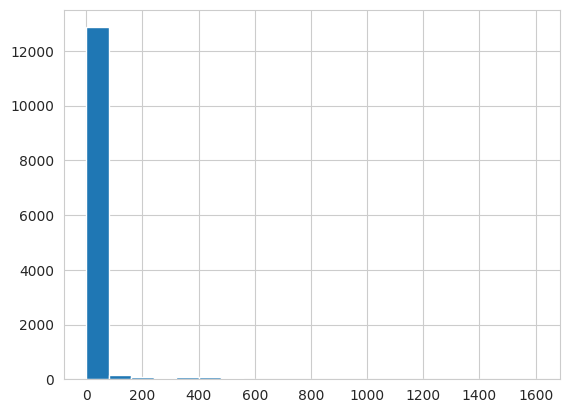

In [30]:
plt.hist(sent_lens,bins=20)

In [31]:
output_seq_len=(np.percentile(sent_lens,95))

In [32]:
output_seq_len

50.0

In [33]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
vectorizer=TextVectorization(max_tokens=333761,output_sequence_length=50,output_mode='int',pad_to_max_tokens=True)
vectorizer.adapt(comments)
import random
random_comment=random.choice(comments)
vectorizer(random_comment)

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([240,  57,   5, 591,   7,   9, 686,  99,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])>

In [34]:
from tensorflow.keras import layers

In [35]:
embedding=layers.Embedding(input_dim=12680,output_dim=128,mask_zero=True)

In [36]:
comment_vocab=vectorizer.get_vocabulary()

In [37]:
len(comment_vocab)

12647

In [38]:
print(f'original comment\n {random_comment}')
print(65*'=')
vectorized_comment=vectorizer(random_comment)
print(f'comment after vectorization\n {vectorized_comment}')
print('='*65)
print(f'comment after embedding\n {embedding(vectorized_comment)}')

original comment
 yes because this singer is a living legend 
comment after vectorization
 [240  57   5 591   7   9 686  99   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
comment after embedding
 [[-0.02367277 -0.00344124  0.04326996 ...  0.03990081  0.02865806
   0.02940397]
 [ 0.03214871  0.0402813  -0.01935561 ...  0.00199687 -0.00059156
  -0.0387718 ]
 [ 0.00796025 -0.00742752 -0.01342421 ...  0.02922357 -0.0346482
   0.01094812]
 ...
 [ 0.04228992  0.01573776 -0.03215476 ... -0.04411475 -0.04058265
   0.0271711 ]
 [ 0.04228992  0.01573776 -0.03215476 ... -0.04411475 -0.04058265
   0.0271711 ]
 [ 0.04228992  0.01573776 -0.03215476 ... -0.04411475 -0.04058265
   0.0271711 ]]


In [39]:
embedding(vectorized_comment).shape

TensorShape([50, 128])

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
train_comments,test_comments,train_labels,test_labels=train_test_split(comments,labels,test_size=0.2)

In [42]:
test_comments[4],test_labels[4]

('this song is love', 1)

In [43]:
train_comments=tf.expand_dims(train_comments,1)
test_comments=tf.expand_dims(test_comments,1)


In [44]:
train_labels=tf.expand_dims(train_labels,1)
test_labels=tf.expand_dims(test_labels,1)

In [45]:
train_dataset=tf.data.Dataset.from_tensor_slices((train_comments,train_labels))
test_dataset=tf.data.Dataset.from_tensor_slices((test_comments,test_labels))

In [46]:
train_dataset=train_dataset.batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(128).prefetch(tf.data.AUTOTUNE)

In [47]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 1), dtype=tf.string, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

In [48]:
inputs=layers.Input(shape=(1,),dtype='string')
x=vectorizer(inputs)
x=embedding(x)
x=layers.Conv1D(128,5,activation='relu',padding='same')(x)
x=layers.Conv1D(128,5,activation='relu',padding='same')(x)
x=layers.Conv1D(128,5,activation='relu',padding='same')(x)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(1,activation='sigmoid')(x)
model_1=tf.keras.models.Model(inputs,outputs)



In [49]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 50)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 50, 128)           1623040   
                                                                 
 conv1d (Conv1D)             (None, 50, 128)           82048     
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 128)           82048     
                                                                 
 conv1d_2 (Conv1D)           (None, 50, 128)           82048     
                                                             

In [50]:
model_1.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
model_1.fit(train_dataset,epochs=100,validation_data=test_dataset)

Epoch 1/100
84/84 [==============================] - 14s 110ms/step - loss: 0.6735 - accuracy: 0.5688 - val_loss: 0.6581 - val_accuracy: 0.5827
Epoch 2/100
84/84 [==============================] - 1s 9ms/step - loss: 0.6157 - accuracy: 0.6511 - val_loss: 0.6675 - val_accuracy: 0.6085
Epoch 3/100
84/84 [==============================] - 1s 8ms/step - loss: 0.5244 - accuracy: 0.7301 - val_loss: 0.7340 - val_accuracy: 0.6007
Epoch 4/100
84/84 [==============================] - 1s 9ms/step - loss: 0.4435 - accuracy: 0.7810 - val_loss: 0.8768 - val_accuracy: 0.5924
Epoch 5/100
84/84 [==============================] - 1s 8ms/step - loss: 0.3829 - accuracy: 0.8105 - val_loss: 1.0170 - val_accuracy: 0.5977
Epoch 6/100
84/84 [==============================] - 1s 9ms/step - loss: 0.3400 - accuracy: 0.8310 - val_loss: 1.1470 - val_accuracy: 0.5981
Epoch 7/100
84/84 [==============================] - 1s 9ms/step - loss: 0.2990 - accuracy: 0.8494 - val_loss: 1.5347 - val_accuracy: 0.6097
Epoch 8/10

In [51]:
def preds_input(model):
  user_input=str(input())
  threshold=0.5
  user_input=np.asarray(user_input)
  user_input=user_input.reshape(1,)
  user_input=tf.constant(user_input)
  pred=model.predict(user_input,verbose=0)
  predicted_label=np.where(pred>=threshold,1,0)
  if int(predicted_label)==1:
    print(f'the comment will get more than 50 likes [YES]')
  else:
    print(f'the comment will get less than 50 likes [NO]')

In [52]:
preds=preds_input(model_1)

Hi man
the comment will get less than 50 likes [NO]


<ipython-input-51-bf2064be17a3>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(predicted_label)==1:


In [53]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
def tokenize_dataset(batch,max_length):
  return tokenizer(batch,return_tensors='tf',max_length=max_length,padding='max_length',truncation=True)

In [55]:
comments_list=comments.tolist()

In [56]:
comments_list[2]

'teacher what is the population of the earth me around one despacito'

In [57]:
dataset_bert=[tokenize_dataset(comment,50) for comment in comments_list]

In [76]:
dataset_bert

[{'input_ids': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
 array([[ 101, 1996, 2111, 2040, 4669, 2023, 7615, 2003, 3985, 2077, 5328,
          102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]], dtype=int32)>},
 {'input_ids': <tf.Tensor: shape=(1, 50), dtype=int32, nu

In [78]:
input_ids_list = [entry['input_ids'].numpy() for entry in dataset_bert]

In [79]:
input_ids_list=[tf.constant(line) for line in input_ids_list]

In [80]:
maxlenids=[line.shape for line in input_ids_list]

In [81]:
maxlenids

[TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShape([1, 50]),
 TensorShap

In [63]:
train_bert_comment,test_bert_comment,train_bert_labels,test_bert_labels=train_test_split(input_ids_list,labels,test_size=0.2)

In [64]:
train_bert_comment[1]

<tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[  101,  2065,  2017,  2079,  2025,  3305,  4759,  2059,  2735,
         2006,  1996,  2394, 14408,  8496,  2066,  2065,  1996, 10293,
         2003,  2204,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]], dtype=int32)>

In [65]:
train_bert_comment=tf.squeeze(train_bert_comment)
test_bert_comment=tf.squeeze(test_bert_comment)

In [66]:
test_bert_labels.shape

(2667,)

In [67]:
train_bert=tf.data.Dataset.from_tensor_slices((train_bert_comment,train_bert_labels))
test_bert=tf.data.Dataset.from_tensor_slices((test_bert_comment,test_bert_labels))
train_bert=train_bert.batch(128).prefetch(tf.data.AUTOTUNE)
test_bert=test_bert.batch(128).prefetch(tf.data.AUTOTUNE)

In [68]:
train_bert

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 50), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [69]:
import numpy as np

In [70]:
class BERT(tf.keras.Model):
  def __init__(self,bert_model,num_classes):
    super().__init__()
    self.bert=bert_model
    self.fc=tf.keras.layers.Dense(num_classes,activation='sigmoid')

  def call(self, inputs, **kwargs):
      outputs = self.bert(inputs, **kwargs)
      logits = outputs.logits  # Make sure to extract the logits from the outputs
      return self.fc(logits)


In [71]:
model_bert=BERT(model,num_classes=1)
model_bert.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam(1e-5))
model_bert.fit(train_bert,epochs=20,validation_data=test_bert)

Epoch 1/20
84/84 [==============================] - 161s 1s/step - loss: 0.6766 - accuracy: 0.5731 - val_loss: 0.6679 - val_accuracy: 0.5939
Epoch 2/20
84/84 [==============================] - 110s 1s/step - loss: 0.6453 - accuracy: 0.6227 - val_loss: 0.6592 - val_accuracy: 0.6157
Epoch 3/20
84/84 [==============================] - 110s 1s/step - loss: 0.6032 - accuracy: 0.6738 - val_loss: 0.6653 - val_accuracy: 0.6187
Epoch 4/20
84/84 [==============================] - 110s 1s/step - loss: 0.5565 - accuracy: 0.7206 - val_loss: 0.6761 - val_accuracy: 0.6112
Epoch 5/20
84/84 [==============================] - 110s 1s/step - loss: 0.4979 - accuracy: 0.7602 - val_loss: 0.7067 - val_accuracy: 0.6179
Epoch 6/20
84/84 [==============================] - 110s 1s/step - loss: 0.4611 - accuracy: 0.7905 - val_loss: 0.7367 - val_accuracy: 0.6239
Epoch 7/20
84/84 [==============================] - 110s 1s/step - loss: 0.3983 - accuracy: 0.8225 - val_loss: 0.9106 - val_accuracy: 0.6228
Epoch 8/20
84

In [72]:
def preds_input_bert(model):
  user_input=str(input())
  threshold=0.5
  user_input=[tokenize_dataset(comment,50) for comment in user_input]
  user_input=[entry['input_ids'].numpy() for entry in user_input]
  user_input=[tf.constant(line) for line in user_input]
  pred=model.predict(user_input[1],verbose=0)
  predicted_label=np.where(pred>=threshold,1,0)
  print(pred)
  if int(predicted_label)==1:
    print(f'the comment will get more than 50 likes [YES]')
  else:
    print(f'the comment will get less than 50 likes [NO]')

In [73]:
preds_input_bert(model_bert)

 privet
[[0.5935683]]
the comment will get more than 50 likes [YES]


<ipython-input-72-dc196dec0107>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(predicted_label)==1:


In [74]:
train_bert

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 50), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [75]:
model_1.evaluate(test_dataset)

21/21 [==============================] - 0s 5ms/step - loss: 5.1125 - accuracy: 0.5864


[5.112491607666016, 0.5864266753196716]